# Quiz 10 Answers

In [1]:
# Working with data:
import numpy  as np                                   # For scientific computing.
import pandas as pd                                   # Working with tables.

# Specific data providers:
from tiingo import TiingoClient                       # Stock prices.
import quandl                                         # Economic data, futures prices, ...

# API keys:
tiingo = TiingoClient({'api_key':'XXXX'})
quandl.ApiConfig.api_key = 'YYYY'

# Plotting:
import matplotlib.pyplot as plt                        # Basic plot library.
plt.style.use('ggplot')                                # Make plots look nice

Q1

In [3]:
sectors = ['XLU','XLY','XLF','XLV']   # utilities, consumer discretionary, financials, health care

PRICE = tiingo.get_dataframe(sectors, '1999-1-1', metric_name='adjClose')
PRICE.index = pd.to_datetime(PRICE.index).tz_convert(None)
RET = PRICE.pct_change()


RATES = quandl.get(['FRED/FEDFUNDS','FRED/DGS1']) / 100
RATES.columns = ['FedFunds','Treasury_1']

In [4]:
import cvxopt
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

In [5]:
# Constrained minimum:
minimum_weight = 0.1
cov = RET['2005':'2010'].cov()

n = len(cov)
P = matrix( cov.values )
q = matrix( np.zeros(n) )
G = matrix( -np.identity(n) ) 
h = matrix( -np.ones(n)*minimum_weight)
A = matrix( np.ones(n), (1,n)) 
b = matrix(1.0)

sol = solvers.qp(P, q, G, h, A, b)

pd.Series({cov.index[i]:sol['x'][i] for i in range(n)})

XLU    0.205526
XLY    0.101074
XLF    0.100161
XLV    0.593239
dtype: float64

Q2

In [6]:
def get_rebalance_dates(frequency, start_date):
    price = PRICE[PRICE.index>start_date]
    group = getattr(price.index, frequency) 
    return price[:1].index.union(price.groupby([price.index.year, group]).tail(1).index)



def compare_performance(t):
    t.add(1).cumprod().plot()
    t.add(1).cumprod().plot(logy=True)

    annual_returns = t[:'2020'].add(1).resample('A').prod().sub(1)
    r_annual_Tbill = RATES.Treasury_1.resample('A').first()

    x = pd.DataFrame()                        
    x['Average_returns']   = annual_returns.mean()
    x['Geometric_average'] = annual_returns.add(1).prod().pow(1/len(annual_returns)).sub(1)
    x['Risk_premium']      = annual_returns.sub(r_annual_Tbill, 'rows').dropna().mean()
    x['Volatility']        = t[:'2020'].std() * 252**0.5    
    x['Sharpe_ratio']      = x.Risk_premium / x.Volatility

    return x




def run_backtest(frequency, backtest_start='1900-1-1'):   
    
    rebalance_dates = get_rebalance_dates(frequency, backtest_start) 

    portfolio_value = pd.Series(1,                        index=[rebalance_dates[0]])    
    weights         = pd.DataFrame(columns=PRICE.columns, index=[rebalance_dates[0]])
    trades          = pd.DataFrame(columns=PRICE.columns, index=[rebalance_dates[0]])

    previous_positions = weights.iloc[0]
        
    for i in range(1, len(rebalance_dates)-1):
        start_date = rebalance_dates[i]
        end_date   = rebalance_dates[i+1]

        cum_ret = RET[start_date:end_date][1:].add(1).cumprod()
                
        start_weights = select_weights(start_date)      # Call "select_weights()" function to get the weights
            
        new_positions = portfolio_value.iloc[-1] * start_weights   

        start_to_end_positions = new_positions  * cum_ret
        start_to_end_value     = start_to_end_positions.sum('columns')

        portfolio_value = portfolio_value.append(start_to_end_value) 
                
        weights = weights.append(start_to_end_positions.div(start_to_end_value,'rows'))                 
                
        trades.loc[start_date] = new_positions - previous_positions 
        previous_positions     = start_to_end_positions.iloc[-1]      # Previous positions for the next rebalance round

    return portfolio_value.pct_change(), weights, trades

In [11]:
def select_weights(date):            
    return pd.Series(1/len(sectors), index=sectors)   # Equal weights (1/n)


portfolio, weights, trades = run_backtest('year', '2006-1-1')
portfolio

2006-01-03         NaN
2007-01-03    0.002631
2007-01-04    0.001610
2007-01-05   -0.009672
2007-01-08    0.001787
                ...   
2021-04-13    0.003895
2021-04-14    0.000173
2021-04-15    0.008292
2021-04-16    0.007589
2021-04-19   -0.004728
Length: 3599, dtype: float64

In [12]:
portfolio.add(1).cumprod().loc['2016-6-7'] * 4000

7388.03312375448

Q3

In [13]:
trades * 4000     # (check 2015)

,XLU,XLY,XLF,XLV
2006-01-03,NaN,NaN,NaN,NaN
2006-12-29,NaN,NaN,NaN,NaN
2007-12-31,-202.687196,119.451260,173.343604,-90.107667
2008-12-31,-60.060472,-20.347288,195.576397,-115.168637
2009-12-31,67.835230,-116.160654,30.220655,18.104768
2010-12-31,52.208551,-120.665918,0.674951,67.782416
2011-12-30,-125.833567,-6.759928,195.332609,-62.739113
2012-12-31,152.263012,-55.070232,-99.342376,2.149595
2013-12-31,217.602767,-103.331553,-25.367060,-88.904154
2014-12-31,-131.535138,145.876326,65.422529,-79.763717


Check returns (we can answer this question without checking returns since we know we always sell assets that outperform and buy assets that underperform to rebalance to equal weights):

In [14]:
RET.add(1).resample('A').prod().sub(1).loc['2015']

,XLU,XLY,XLF,XLV
2015-12-31,-0.049107,0.099156,-0.017406,0.068424


Q6:

In [15]:
x = RET['2005':'2019'].XLY.add(1).resample('A').prod()
x

2005-12-31    0.934292
2006-12-31    1.188433
2007-12-31    0.861971
2008-12-31    0.670312
2009-12-31    1.405748
2010-12-31    1.274627
2011-12-31    1.059865
2012-12-31    1.235985
2013-12-31    1.427364
2014-12-31    1.094633
2015-12-31    1.099156
2016-12-31    1.059715
2017-12-31    1.228201
2018-12-31    1.015919
2019-12-31    1.283939
Freq: A-DEC, Name: XLY, dtype: float64

In [16]:
x.prod()**(1/len(x)) - 1

0.10365609991617819

Q7:

In [17]:
positons = pd.Series({'XLU':50, 'XLF':80, 'XLV':40})
positons

XLU    50
XLF    80
XLV    40
dtype: int64

In [18]:
# value of $1 in each asset:
RET['2010':'2020'].add(1).cumprod()

,XLU,XLY,XLF,XLV
2010-01-04,1.001934,1.007726,1.020139,1.017380
2010-01-05,0.990006,1.011421,1.038889,1.007403
2010-01-06,0.995809,1.012765,1.040972,1.017702
2010-01-07,0.991296,1.021162,1.063194,1.021242
2010-01-08,0.990329,1.020826,1.056944,1.022852
...,...,...,...,...
2020-12-24,2.941845,6.196979,3.017244,4.349305
2020-12-28,2.954822,6.267631,3.031835,4.360230
2020-12-29,2.954341,6.269593,3.021413,4.380909
2020-12-30,2.969240,6.307275,3.034962,4.380129


In [19]:
portfolio_value = RET['2010':'2020'].add(1).cumprod().multiply(positons).sum('columns')
portfolio_value

2010-01-04    172.403027
2010-01-05    172.907539
2010-01-06    173.776314
2010-01-07    175.470047
2010-01-08    174.986062
                 ...    
2020-12-24    562.443977
2020-12-28    564.697098
2020-12-29    564.666463
2020-12-30    566.464117
2020-12-31    573.518193
Length: 2769, dtype: float64

In [20]:
portfolio_value.pct_change().add(1).resample('A').prod().sub(1).mean()

0.12095243171335067

In [21]:
# This calculation ignores the return of the the first year:
portfolio_value.resample('A').last().pct_change()

2010-12-31         NaN
2011-12-31    0.000538
2012-12-31    0.162316
2013-12-31    0.303224
2014-12-31    0.213865
2015-12-31   -0.001578
2016-12-31    0.130658
2017-12-31    0.192671
2018-12-31   -0.035808
2019-12-31    0.268755
2020-12-31    0.031489
Freq: A-DEC, dtype: float64

In [22]:
# Mean, without the first year return:
portfolio_value.resample('A').last().pct_change().mean()

0.12661305479479024

Q8:

In [23]:
def select_weights(date):   
    cov = RET[sectors][:date][-250:].cov()
    minimum_weight = 0
    n = len(cov)
    P = matrix(  cov.values )
    q = matrix(  np.zeros(n) )
    G = matrix( -np.identity(n) )  
    h = matrix( -np.ones(n)*minimum_weight )
    A = matrix(  np.ones(n), (1,n))  
    b = matrix(1.0)
    sol = solvers.qp(P, q, G, h, A, b)
    return pd.Series({cov.index[i]:sol['x'][i] for i in range(n)})


mv_cvxopt, weights, trades = run_backtest('quarter', '2000-1-1')
mv_cvxopt = mv_cvxopt.rename('MinVol_cvxopt')

t = pd.DataFrame(mv_cvxopt)[:'2015']
t

,MinVol_cvxopt
2000-01-03,NaN
2000-04-03,0.008457
2000-04-04,0.001537
2000-04-05,0.005193
2000-04-06,0.010844
...,...
2015-12-24,-0.001506
2015-12-28,0.001609
2015-12-29,0.008886
2015-12-30,-0.004899


,Average_returns,Geometric_average,Risk_premium,Volatility,Sharpe_ratio
MinVol_cvxopt,0.06585,0.055911,0.045013,0.165255,0.272382


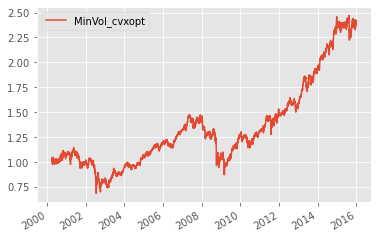

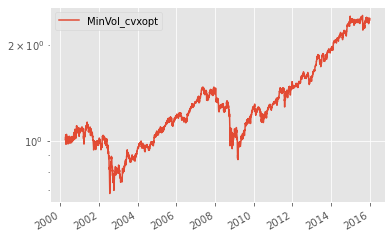

In [24]:
compare_performance(t)

Q9:

In [25]:
RET = RET.join(RATES.FedFunds.rename('MarginLoan'), how='outer')
RET['MarginLoan'] = RET.MarginLoan.ffill()/252 + 0.01/252           # Assume margin rate = fed funds rate + 100 bsp
RET = RET.dropna(subset=['XLF'])
RET

,XLU,XLY,XLF,XLV,MarginLoan
1999-01-05,0.012101,0.016943,0.009386,0.015420,0.000223
1999-01-06,0.010296,0.028398,0.031699,0.016705,0.000223
1999-01-07,-0.003616,-0.001105,0.015158,-0.004481,0.000223
1999-01-08,0.005609,0.001106,0.006457,0.012003,0.000223
1999-01-11,-0.026575,-0.005155,-0.015237,0.002595,0.000223
...,...,...,...,...,...
2021-04-13,0.011868,0.010558,-0.009348,0.004150,0.000042
2021-04-14,0.004417,-0.009834,0.006005,-0.000084,0.000042
2021-04-15,0.011071,0.007166,-0.000853,0.017124,0.000042
2021-04-16,0.008100,0.007732,0.007112,0.007464,0.000042


In [26]:
def select_weights(date):   
    cov = RET[sectors][:date][-250:].cov()
    minimum_weight = 0
    n = len(cov)
    P = matrix(  cov.values )
    q = matrix(  np.zeros(n) )
    G = matrix( -np.identity(n) )  
    h = matrix( -np.ones(n)*minimum_weight )
    A = matrix(  np.ones(n), (1,n))  
    b = matrix(1.0)
    sol = solvers.qp(P, q, G, h, A, b)
    w = pd.Series({cov.index[i]:sol['x'][i] for i in range(n)})
    w = w.multiply(1.4).append(pd.Series({'MarginLoan':-0.4}))   # Weights with leverage
    return w


mv_cvxopt, weights, trades = run_backtest('quarter', '2000-1-1')
mv_cvxopt = mv_cvxopt.rename('MinVol_cvxopt')

t = pd.DataFrame(mv_cvxopt)
t[:'2015'].add(1).cumprod() * 1000

,MinVol_cvxopt
2000-01-03,NaN
2000-04-03,1011.728021
2000-04-04,1013.787257
2000-04-05,1021.018325
2000-04-06,1036.319274
...,...
2015-12-24,2646.682495
2015-12-28,2652.503546
2015-12-29,2684.933378
2015-12-30,2666.819112


Q10:

In [27]:
vol = RET[sectors].loc['2000'].std()

(1/vol) / (1/vol).sum()

XLU    0.304868
XLY    0.218401
XLF    0.210320
XLV    0.266412
dtype: float64

Q11:

In [28]:
def select_weights(date):   
    vol = RET[sectors][:date][-30:].std()
    return (1/vol) / (1/vol).sum()


v, weights, trades = run_backtest('month', '2000-1-1')
v.add(1).cumprod()[:'2020'] * 5000

2000-01-03             NaN
2000-02-01     5060.037056
2000-02-02     5056.892257
2000-02-03     5062.597411
2000-02-04     5042.095495
                  ...     
2020-12-24    25231.428939
2020-12-28    25380.441601
2020-12-29    25399.439534
2020-12-30    25495.640773
2020-12-31    25731.594430
Length: 5265, dtype: float64